In [1]:
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm

In [2]:
class World:
    def __init__(self,debug = False):
        self.objects = []
        self.debug = debug
        
    def append(self,obj):
        self.objects.append(obj)# world座標系にobjを入れる
        
    def draw(self):
        # グラフの用意
        fig = plt.figure(figsize = (4,4))# 8*8インチの図を用意 図を描くのに必要
        ax = fig.add_subplot(111) # サブプロット １行１列の１番目を作るという宣言
        ax.set_aspect('equal') # 縦横比を座標の値と揃える
        ax.set_xlim(-5,5) # x軸 -5m~5m
        ax.set_ylim(-5,5) # y軸 -5m~5m
        ax.set_xlabel("X",fontsize = 10) #ラベル
        ax.set_ylabel("Y",fontsize = 10)
        
        elems = []
        
        if self.debug:
            for i in range(1000):self.one_step(i,elems,ax) # デバッグ時にアニメーションをさせない
        else:
            self.ani = anm.FuncAnimation(fig,self.one_step,fargs = (elems,ax),
                                         frames = 10,interval = 1000,repeat = False)
            plt.show()
        
    def one_step(self,i,elems,ax):
        while elems: elems.pop().remove() # 二重で描かれないように
        elems.append(ax.text(-4.4,4.5,"t = "+str(i),fontsize = 10))
        for obj in self.objects:
            obj.draw(ax,elems)
            if hasattr(obj,"one_step"): obj.one_step(1.0)

In [3]:
class IdealRobot:
    def __init__(self,pose,agent = None,color = "black"):
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [pose]
    # r:ロボットの半径
    def draw(self,ax,elems):
        x,y,theta = self.pose
        xn = x + self.r * math.cos(theta)
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([x,xn],[y,yn],color = self.color)
        c = patches.Circle(xy = (x,y),radius = self.r,fill = False,color = self.color)
        elems.append(ax.add_patch(c))
        
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses],[e[1] for e in self.poses],linewidth = 0.5,color = "black")
    
    # 移動後の状態を返す
    @classmethod
    def state_transition(cls,nu,omega,time,pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array([nu * math.cos(t0),nu * math.sin(t0),omega]) * time
        
        else:
            return pose + np.array([nu / omega * (math.sin(t0 + omega * time) - math.sin(t0)),
                                    nu / omega * (-math.cos(t0 + omega * time) + math.cos(t0)),omega * time])
    
    # 速度角速度取得
    def one_step(self,time_interval):
        if not self.agent: return #self.agentが空
        nu,omega = self.agent.decision()
        # time_interval:１ステップが何秒か指定
        self.pose = self.state_transition(nu,omega,time_interval,self.pose)

In [4]:
# 原点スタート　0.1[m/s]で1秒前進
IdealRobot.state_transition(0.1,0.0,1.0,np.array([0,0,0]).T)

array([0.1, 0. , 0. ])

In [5]:
IdealRobot.state_transition(0.1,10.0 / 180 * math.pi,9.0,np.array([0,0,0]).T)

array([0.5729578 , 0.5729578 , 1.57079633])

In [6]:
IdealRobot.state_transition(0.1,10.0 / 180 * math.pi,18.0,np.array([0,0,0]).T)

array([7.01670930e-17, 1.14591559e+00, 3.14159265e+00])

In [7]:
class Agent:
    def __init__(self,nu,omega):
        self.nu = nu;
        self.omega = omega
    
    # selfに格納されているパラメータをバラす
    def decision(self,observation = None):
        return self.nu,self.omega
    

<IPython.core.display.Javascript object>


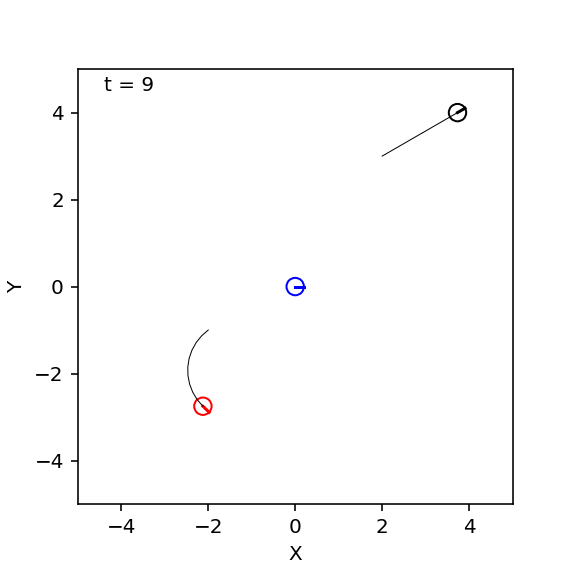

In [8]:
world = World()
straight = Agent(0.2,0.0)
circling = Agent(0.2,10.0 / 180 * math.pi)
robot1 = IdealRobot(np.array([2,3,math.pi/6]).T,agent = straight) #(x,y,θ) = (2,3,π/6) .T -> 転置
robot2 = IdealRobot(np.array([-2,-1,math.pi/5*6]).T,agent = circling,color = "red")
robot3 = IdealRobot(np.array([0,0,0]).T,color = "blue")

world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()